<a href="https://colab.research.google.com/github/rr250/Fixing-Image-Denoising-Using-GAN/blob/master/Copy_of_Rephrase_Research_Engineer_Problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Statement

You are given the original and degraded versions of a few images. Your task is to write a GAN which can fix the degraded images.

Complete the function `fix` at the end of the "Evaluation" block so that it can take a degraded image, and return a fixed image (that looks as much like the original non-degraded version as possible).

Before submission, get this notebook in a state such that the `fix` function can directly be called on an image.

#Setup

## Intended Structure after Setup

Run the blocks in this section to get the following directory structure:
```
/content
│
└───rephrase-pubfig831
    │
    └───correct
    │   │
    │   └───train
    │   │   │
    │   │   └───Adam Sandler
    │   │   │   │   train__000001-000000.jpg
    │   │   │   │   train__000001-000001.jpg
    │   │   │   │   train__000001-000002.jpg
    │   │   │   │   ...
    │   │   │
    │   │   └───Alec Baldwin
    │   │   │   │   train__000002-000000.jpg
    │   │   │   │   train__000002-000001.jpg
    │   │   │   │   ...
    │   │   │
    │   │   └───Angelina Jolie
    │   │   │   │   train__000003-000000.jpg
    │   │   │   │   train__000003-000001.jpg
    │   │   │   │   ...
    │   │   │
    │   │   │ ...
    │   │
    │   └───test
    │       │
    │       └───Adam Sandler
    │       │   │   test__000001-000000.jpg
    │       │   │   test__000001-000001.jpg
    │       │   │   ...
    │       │
    │       └───Alec Baldwin
    │       │   │   test__000002-000000.jpg
    │       │   │   ...
    │       │
    │       └───Angelina Jolie
    │       │   │   test__000003-000000.jpg
    │       │   │   ...
    │       │
    │       │ ...
    │
    │
    └───degraded
        │   <Same directory structure as 'correct'>
```

Every image in the degraded directory is a degraded version of the image with the same name in the correct directory. e.g. `/content/rephrase-pubfig831/degraded/Adam Sandler/train__000001-000002.jpg` is the degraded version of `/content/rephrase-pubfig831/correct/Adam Sandler/train__000001-000002.jpg`

## Installation (pip etc)
Add any other installation commands you want to in this block. **Restart Runtime** after this block.

In [0]:
!pip install tensorlayer
!pip install --upgrade tensorflow
!pip install --upgrade tensorflow-gpu
!pip install numpy==1.16.1
!pip install GPUtil
!pip install tqdm
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi

## Downloading and Generating Dataset
Run this block only once. Do not modify it.

In [0]:
import os
from glob import glob
import cv2
import numpy as np
from tqdm import tqdm

def degrade(path: str) -> None:
    """Load image at `input_path`, distort and save as `output_path`"""
    SHIFT = 2
    image = cv2.imread(path)
    to_swap = np.random.choice([False, True], image.shape[:2], p=[.8, .2])
    swap_indices = np.where(to_swap[:-SHIFT] & ~to_swap[SHIFT:])
    swap_vals = image[swap_indices[0] + SHIFT, swap_indices[1]]
    image[swap_indices[0] + SHIFT, swap_indices[1]] = image[swap_indices]
    image[swap_indices] = swap_vals
    cv2.imwrite(path, image)

!wget http://briancbecker.com/files/downloads/pubfig83lfw/pubfig83lfw_raw_in_dirs.zip
!unzip -q pubfig83lfw_raw_in_dirs.zip
!rm pubfig83lfw_raw_in_dirs.zip
!mkdir rephrase-pubfig831
!mv pubfig83lfw_raw_in_dirs rephrase-pubfig831/correct
!rm -r rephrase-pubfig831/correct/distract
!cp -r rephrase-pubfig831/correct rephrase-pubfig831/degraded

for image_path in tqdm(glob('rephrase-pubfig831/degraded/*/*/*.jpg')):
  degrade(image_path)

--2019-10-25 13:21:41--  http://briancbecker.com/files/downloads/pubfig83lfw/pubfig83lfw_raw_in_dirs.zip
Resolving briancbecker.com (briancbecker.com)... 162.241.216.158
Connecting to briancbecker.com (briancbecker.com)|162.241.216.158|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 400247922 (382M) [application/zip]
Saving to: ‘pubfig83lfw_raw_in_dirs.zip’

pubfig83lfw_raw_in_ 100%[===================>] 381.71M  16.1MB/s    in 25s     

2019-10-25 13:22:07 (15.1 MB/s) - ‘pubfig83lfw_raw_in_dirs.zip’ saved [400247922/400247922]



100%|██████████| 13002/13002 [01:01<00:00, 212.92it/s]


# **Checking Free Memory**
This block is just so that you can have an idea of the resources you have at hand on the Google Collab system.

In [0]:
import psutil
import humanize
import os
import GPUtil as GPU
gpu = GPU.getGPUs()[0]
process = psutil.Process(os.getpid())
print(f"Gen RAM: Free {humanize.naturalsize(psutil.virtual_memory().available)} | Proc size {humanize.naturalsize(process.memory_info().rss)}")
print(f"GPU RAM: Free {gpu.memoryFree:.0f}MB | Used {gpu.memoryUsed:.0f}MB | Util {gpu.memoryUtil*100:.0f}% | Total {gpu.memoryTotal:.0f}MB")

Gen RAM: Free 12.8 GB | Proc size 171.5 MB
GPU RAM: Free 11441MB | Used 0MB | Util 0% | Total 11441MB


# **Main Code**

In [0]:
import time
import random
import scipy, multiprocessing
import tensorflow as tf
import tensorlayer as tl
import os
from glob import glob
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import random
import numpy as np
import scipy, multiprocessing
import tensorflow as tf
import tensorlayer as tl
from tensorlayer.layers import (Input, Conv2d, BatchNorm2d, Elementwise, SubpixelConv2d, Flatten, Dense)
from tensorlayer.models import Model

## Data Loading

In [0]:
def get_train_data():
    train_hr_img_lists=glob('rephrase-pubfig831/correct/train/*/*.jpg')
    train_hr_imgs=[]
    i=1
    for train_hr_img_list in train_hr_img_lists:
        train_hr_imgs.append(tl.vis.read_image(train_hr_img_list))  
        # i+=1
        # if(i==1000):
        #   break
    def generator_train():
        for img in train_hr_imgs:
            yield img
    def _map_fn_train(img):
        hr_patch = tf.image.random_crop(img, [250, 250, 3])
        hr_patch = tf.image.resize(hr_patch, size=[250, 250])
        hr_patch = hr_patch / (255. / 2.)
        hr_patch = hr_patch - 1.
        hr_patch = tf.image.random_flip_left_right(hr_patch)
        lr_patch = tf.image.resize(hr_patch, size=[250, 250])
        return lr_patch, hr_patch
    train_ds = tf.data.Dataset.from_generator(generator_train, output_types=(tf.float32))
    train_ds = train_ds.map(_map_fn_train, num_parallel_calls=multiprocessing.cpu_count())
    train_ds = train_ds.shuffle(shuffle_buffer_size)
    train_ds = train_ds.prefetch(buffer_size=2)
    train_ds = train_ds.batch(batch_size)
    return train_ds

## Structure

### **Constants and Hyperparemeters**

Since Google Colab doesn't have **good resources we should use lower batch_size and less epochs** otherwise with my calculations training might take approximately half a year.
**I tried for 10 epochs due to time restrictions and could see minute improvements** but to see good results we have to try atleast 1000 epochs.

In [0]:
batch_size = 16
n_epoch_init = 10
n_epoch = 100
# if you have better resources and time
# batch_size = 16
# n_epoch_init = 200
# n_epoch = 2000
lr_init = 1e-4
beta1 = 0.9
lr_decay = 0.1
decay_every = 2
shuffle_buffer_size = 128
save_dir = "samples"
tl.files.exists_or_mkdir(save_dir)
checkpoint_dir = "models"
tl.files.exists_or_mkdir(checkpoint_dir)

[TL] [*] creates samples ...
[TL] [*] creates models ...


False

### Generator Model

In [0]:
def get_G(input_shape):
    w_init = tf.random_normal_initializer(stddev=0.02)
    g_init = tf.random_normal_initializer(1., 0.02)

    nin = Input(input_shape)
    n = Conv2d(16, (3, 3), (1, 1), act=tf.nn.relu, padding='SAME', W_init=w_init)(nin)
    temp = n

    # B residual blocks
    for i in range(4):
        nn = Conv2d(16, (3, 3), (1, 1), padding='SAME', W_init=w_init, b_init=None)(n)
        nn = BatchNorm2d(act=tf.nn.relu, gamma_init=g_init)(nn)
        nn = Conv2d(16, (3, 3), (1, 1), padding='SAME', W_init=w_init, b_init=None)(nn)
        nn = BatchNorm2d(gamma_init=g_init)(nn)
        nn = Elementwise(tf.add)([n, nn])
        n = nn

    n = Conv2d(16, (3, 3), (1, 1), padding='SAME', W_init=w_init, b_init=None)(n)
    n = BatchNorm2d(gamma_init=g_init)(n)
    n = Elementwise(tf.add)([n, temp])
    # B residual blacks end

    n = Conv2d(64, (3, 3), (1, 1), padding='SAME', W_init=w_init)(n)
    #n = SubpixelConv2d(scale=2, n_out_channels=None, act=tf.nn.relu)(n)

    n = Conv2d(64, (3, 3), (1, 1), act=None, padding='SAME', W_init=w_init)(n)
    #n = SubpixelConv2d(scale=2, n_out_channels=None, act=tf.nn.relu)(n)

    nn = Conv2d(3, (1, 1), (1, 1), act=tf.nn.tanh, padding='SAME', W_init=w_init)(n)
    G = Model(inputs=nin, outputs=nn)
    return G


### Discriminator Model

In [0]:
def get_D(input_shape):
    w_init = tf.random_normal_initializer(stddev=0.02)
    gamma_init = tf.random_normal_initializer(1., 0.02)
    df_dim = 8
    lrelu = lambda x: tl.act.lrelu(x, 0.2)

    nin = Input(input_shape)
    n = Conv2d(df_dim, (4, 4), (2, 2), act=lrelu, padding='SAME', W_init=w_init)(nin)

    n = Conv2d(df_dim * 2, (4, 4), (2, 2), padding='SAME', W_init=w_init, b_init=None)(n)
    n = BatchNorm2d(act=lrelu, gamma_init=gamma_init)(n)
    n = Conv2d(df_dim * 4, (4, 4), (2, 2), padding='SAME', W_init=w_init, b_init=None)(n)
    n = BatchNorm2d(act=lrelu, gamma_init=gamma_init)(n)
    n = Conv2d(df_dim * 8, (4, 4), (2, 2), padding='SAME', W_init=w_init, b_init=None)(n)
    n = BatchNorm2d(act=lrelu, gamma_init=gamma_init)(n)
    n = Conv2d(df_dim * 16, (4, 4), (2, 2), padding='SAME', W_init=w_init, b_init=None)(n)
    n = BatchNorm2d(act=lrelu, gamma_init=gamma_init)(n)
    n = Conv2d(df_dim * 32, (4, 4), (2, 2), padding='SAME', W_init=w_init, b_init=None)(n)
    n = BatchNorm2d(act=lrelu, gamma_init=gamma_init)(n)
    n = Conv2d(df_dim * 16, (1, 1), (1, 1), padding='SAME', W_init=w_init, b_init=None)(n)
    n = BatchNorm2d(act=lrelu, gamma_init=gamma_init)(n)
    n = Conv2d(df_dim * 8, (1, 1), (1, 1), padding='SAME', W_init=w_init, b_init=None)(n)
    nn = BatchNorm2d(gamma_init=gamma_init)(n)

    n = Conv2d(df_dim * 2, (1, 1), (1, 1), padding='SAME', W_init=w_init, b_init=None)(nn)
    n = BatchNorm2d(act=lrelu, gamma_init=gamma_init)(n)
    n = Conv2d(df_dim * 2, (3, 3), (1, 1), padding='SAME', W_init=w_init, b_init=None)(n)
    n = BatchNorm2d(act=lrelu, gamma_init=gamma_init)(n)
    n = Conv2d(df_dim * 8, (3, 3), (1, 1), padding='SAME', W_init=w_init, b_init=None)(n)
    n = BatchNorm2d(gamma_init=gamma_init)(n)
    n = Elementwise(combine_fn=tf.add, act=lrelu)([n, nn])

    n = Flatten()(n)
    no = Dense(n_units=1, W_init=w_init)(n)
    D = Model(inputs=nin, outputs=no)
    return D

### Loss Functions

For Discriminator and Generatot we are going to use Sigmoid Cross-Entropy
We are also going to use vgg19 features and use them in our loss functions.

In [0]:
# d_loss1 = tl.cost.sigmoid_cross_entropy(logits_real, tf.ones_like(logits_real))
# d_loss2 = tl.cost.sigmoid_cross_entropy(logits_fake, tf.zeros_like(logits_fake))
# d_loss = d_loss1 + d_loss2
# g_gan_loss = 1e-3 * tl.cost.sigmoid_cross_entropy(logits_fake, tf.ones_like(logits_fake))
# mse_loss = tl.cost.mean_squared_error(fake_patchs, hr_patchs, is_mean=True)
# vgg_loss = 2e-6 * tl.cost.mean_squared_error(feature_fake, feature_real, is_mean=True)
# g_loss = mse_loss + vgg_loss + g_gan_loss

### Optimizer

We are going to use Adam Optimizer instead of RMSPRop and AdaGrad that's why we will use this

In [0]:
# g_optimizer_init = tf.optimizers.Adam(lr_v, beta_1=beta1)
# g_optimizer = tf.optimizers.Adam(lr_v, beta_1=beta1)
# d_optimizer = tf.optimizers.Adam(lr_v, beta_1=beta1)

## Training

In [0]:
def train():
    G = get_G((batch_size, 250, 250, 3))
    D = get_D((batch_size, 250, 250, 3))

    lr_v = tf.Variable(lr_init)
    g_optimizer_init = tf.optimizers.Adam(lr_v, beta_1=beta1)
    g_optimizer = tf.optimizers.Adam(lr_v, beta_1=beta1)
    d_optimizer = tf.optimizers.Adam(lr_v, beta_1=beta1)

    G.train()
    D.train()

    train_ds = get_train_data()

    ## initialize learning (G)
    n_step_epoch = round(n_epoch_init // batch_size)
    for epoch in range(n_epoch_init):
        for step, (lr_patchs, hr_patchs) in enumerate(train_ds):
            if lr_patchs.shape[0] != batch_size: # if the remaining data in this epoch < batch_size
                break
            step_time = time.time()
            with tf.GradientTape() as tape:
                fake_hr_patchs = G(lr_patchs)
                mse_loss = tl.cost.mean_squared_error(fake_hr_patchs, hr_patchs, is_mean=True)
            grad = tape.gradient(mse_loss, G.trainable_weights)
            g_optimizer_init.apply_gradients(zip(grad, G.trainable_weights))
            print("Epoch: [{}/{}] step: [{}] time: {:.3f}s, mse: {:.3f} ".format(
                epoch, n_epoch_init, step, time.time() - step_time, mse_loss))
        if (epoch != 0) and (epoch % 1 == 0):
            tl.vis.save_images(fake_hr_patchs.numpy(), [4, 4], os.path.join(save_dir, 'train_g_init_{}.png'.format(epoch)))

    ## adversarial learning (G, D)
    n_step_epoch = round(n_epoch // batch_size)
    for epoch in range(n_epoch):
        for step, (lr_patchs, hr_patchs) in enumerate(train_ds):
            if lr_patchs.shape[0] != batch_size: # if the remaining data in this epoch < batch_size
                break
            step_time = time.time()
            with tf.GradientTape(persistent=True) as tape:
                fake_patchs = G(lr_patchs)
                logits_fake = D(fake_patchs)
                logits_real = D(hr_patchs)
                d_loss1 = tl.cost.sigmoid_cross_entropy(logits_real, tf.ones_like(logits_real))
                d_loss2 = tl.cost.sigmoid_cross_entropy(logits_fake, tf.zeros_like(logits_fake))
                d_loss = d_loss1 + d_loss2
                g_gan_loss = 1e-3 * tl.cost.sigmoid_cross_entropy(logits_fake, tf.ones_like(logits_fake))
                mse_loss = tl.cost.mean_squared_error(fake_patchs, hr_patchs, is_mean=True)
                g_loss = mse_loss + g_gan_loss
            grad = tape.gradient(g_loss, G.trainable_weights)
            g_optimizer.apply_gradients(zip(grad, G.trainable_weights))
            grad = tape.gradient(d_loss, D.trainable_weights)
            d_optimizer.apply_gradients(zip(grad, D.trainable_weights))
            print("Epoch: [{}/{}] step: [{}] time: {:.3f}s, g_loss(mse:{:.3f}, adv:{:.3f}) d_loss: {:.3f}".format(
                epoch, n_epoch, step, time.time() - step_time, mse_loss, g_gan_loss, d_loss))

        # update the learning rate
        if epoch != 0 and (epoch % decay_every == 0):
            new_lr_decay = lr_decay**(epoch // decay_every)
            lr_v.assign(lr_init * new_lr_decay)
            log = " ** new learning rate: %f (for GAN)" % (lr_init * new_lr_decay)
            print(log)

        if (epoch != 0):
            tl.vis.save_images(fake_patchs.numpy(), [4, 4], os.path.join(save_dir, 'train_g_{}.png'.format(epoch)))
            G.save_weights(os.path.join(checkpoint_dir, 'g.h5'))
            D.save_weights(os.path.join(checkpoint_dir, 'd.h5'))

In [0]:
train()

Epoch: [44/100] step: [136] time: 1.391s, g_loss(mse:0.001, adv:0.001) d_loss: 1.149
Epoch: [44/100] step: [137] time: 1.397s, g_loss(mse:0.001, adv:0.001) d_loss: 0.723
Epoch: [44/100] step: [138] time: 1.391s, g_loss(mse:0.001, adv:0.002) d_loss: 0.914
Epoch: [44/100] step: [139] time: 1.390s, g_loss(mse:0.001, adv:0.001) d_loss: 0.965
Epoch: [44/100] step: [140] time: 1.402s, g_loss(mse:0.001, adv:0.002) d_loss: 0.323
Epoch: [44/100] step: [141] time: 1.386s, g_loss(mse:0.001, adv:0.002) d_loss: 0.531
Epoch: [44/100] step: [142] time: 1.387s, g_loss(mse:0.001, adv:0.001) d_loss: 0.829
Epoch: [44/100] step: [143] time: 1.398s, g_loss(mse:0.001, adv:0.002) d_loss: 0.672
Epoch: [44/100] step: [144] time: 1.393s, g_loss(mse:0.001, adv:0.002) d_loss: 0.565
Epoch: [44/100] step: [145] time: 1.374s, g_loss(mse:0.001, adv:0.002) d_loss: 0.544
Epoch: [44/100] step: [146] time: 1.387s, g_loss(mse:0.001, adv:0.000) d_loss: 1.285
Epoch: [44/100] step: [147] time: 1.385s, g_loss(mse:0.002, adv:0

## Evaluation

In [0]:
def fix(image: np.ndarray) -> np.ndarray:
    """
    This function should take a degraded image in BGR format as a 250x250x3
    numpy array, and return its fixed version in the same format.
    """
    G = get_G([1, 250, 250, 3])
    G.load_weights(os.path.join(checkpoint_dir, 'g.h5'))
    G.eval()

    image = np.asarray(image, dtype=np.float32)
    image = image[np.newaxis,:,:,:]
    size = [image.shape[1], image.shape[2]]

    outimage = G(image).numpy()
    outimage = tf.image.resize(outimage, size=[250, 250])
    outimage = np.asarray(outimage, dtype=np.float32)
    outimage = outimage[0]
    return outimage

# Results
Run this block after done to look at some of the results of the fix function yourself.

[TL] Input  _inputlayer_6: [1, 250, 250, 3]
[TL] Conv2d conv2d_66: n_filter: 16 filter_size: (3, 3) strides: (1, 1) pad: SAME act: relu
[TL] Conv2d conv2d_67: n_filter: 16 filter_size: (3, 3) strides: (1, 1) pad: SAME act: No Activation
[TL] BatchNorm batchnorm2d_46: decay: 0.900000 epsilon: 0.000010 act: relu is_train: False
[TL] Conv2d conv2d_68: n_filter: 16 filter_size: (3, 3) strides: (1, 1) pad: SAME act: No Activation
[TL] BatchNorm batchnorm2d_47: decay: 0.900000 epsilon: 0.000010 act: No Activation is_train: False
[TL] Elementwise elementwise_26: fn: add act: No Activation
[TL] Conv2d conv2d_69: n_filter: 16 filter_size: (3, 3) strides: (1, 1) pad: SAME act: No Activation
[TL] BatchNorm batchnorm2d_48: decay: 0.900000 epsilon: 0.000010 act: relu is_train: False
[TL] Conv2d conv2d_70: n_filter: 16 filter_size: (3, 3) strides: (1, 1) pad: SAME act: No Activation
[TL] BatchNorm batchnorm2d_49: decay: 0.900000 epsilon: 0.000010 act: No Activation is_train: False
[TL] Elementwise e

Lossy conversion from float64 to uint8. Range [-1.0, 1.0]. Convert image to uint8 prior to saving to suppress this warning.


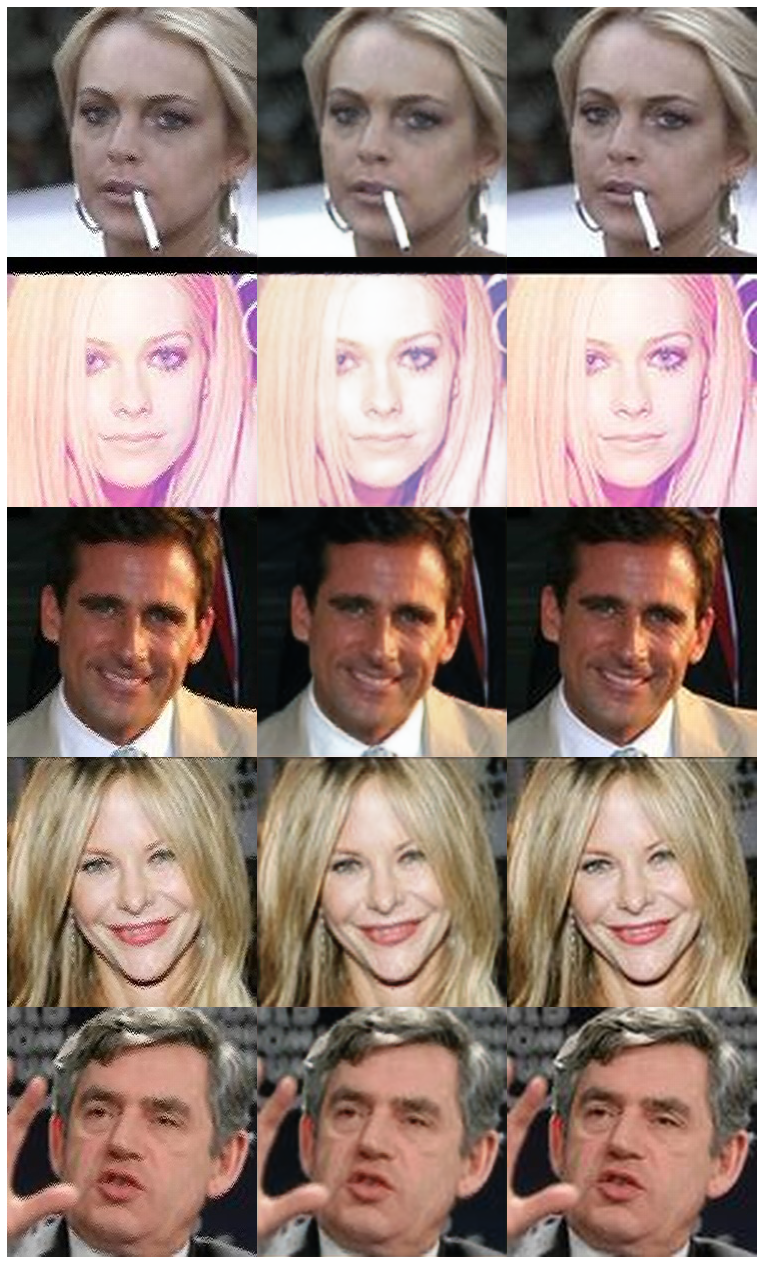

In [0]:
%matplotlib inline

import os
import random
from glob import glob

import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

NUM_DISPLAY = 5

files = glob('/content/rephrase-pubfig831/correct/test/*/*.jpg')
grid = []

for path in random.sample(files, NUM_DISPLAY):
  correct = tl.vis.read_image(path)
  correct = (correct / 127.5) - 1
  split = path.split('/')
  degraded = tl.vis.read_image('/'.join([*split[:3], 'degraded', *split[4:]]))
  degraded = (degraded / 127.5) - 1
  fixed = fix(degraded)
  grid.append(np.column_stack([degraded, fixed, correct]))

image = np.row_stack(grid)
tl.vis.save_image(image, os.path.join(save_dir, 'grid.png'))
img=mpimg.imread(os.path.join(save_dir, 'grid.png'))
dpi = float(plt.rcParams['figure.dpi'])
figsize = image.shape[1] / dpi, image.shape[0] / dpi
ax = plt.figure(figsize=figsize).add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(img)
plt.show()